# Experiment output analysis

In [7]:
import numpy as np
import pandas as pd
import pathlib
import os

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_pinball_loss

## Set experiment design parameters

In [8]:
experiments = [
#     "autoarima",
#     "autogluon_NaiveModel",
#     "autogluon_SeasonalNaiveModel",
#     "autogluon_ARIMAModel",
#     "autogluon_ETSModel",
#     "autogluon_AutoETSModel",
#     "autogluon_DLinearModel",
#     "autogluon_DeepARModel",
#     "autogluon_DirectTabularModel",
#     "autogluon_RecursiveTabularModel",
#     # "autogluon_SimpleFeedForwardModel",
#     "autogluon_TemporalFusionTransformerModel",
#     "neuralprophet_uni",
#     "neuralprophet_covariates",
#     "neuralprophet_covariates_onlyclimate",
#     "neuralprophet_covariates_noclimate",
#     "autogluon_with_covariates_TemporalFusionTransformerModel",
#     "autogluon_with_scaled_covariates_DirectTabularModel",
#     "autogluon_with_covariates_Energy_EXCAUS_TemporalFusionTransformerModel",
#     "autogluon_preset_best_quality_global_model_best_quality",
#     "autogluon_global_with_covariates_experiment_TemporalFusionTransformerModel",
#     "autogluon_global_with_covariates_experiment_DirectTabularModel",
#     "autogluon_global_with_scaled_covariates_experiment_preset_best_quality",
#     "autogluon_global_with_scaled_covariates_experiment_TemporalFusionTransformerModel",
#     "autogluon_with_scaled_covariates_mean_SWE_TemporalFusionTransformerModel",
#     "autogluon_with_scaled_covariates_mean_SWE_DirectTabularModel",
]

experiments = [
'autogluon_preset_best_quality_global_model_NaiveModel'
# 'autoarima',
# 'autogluon_global_scaled_covariates_DeepARModel',
# 'autogluon_global_with_scaled_covariates_DeepARModel',
# 'autogluon_NaiveModel',
# 'autogluon_scaled_covariates_ARIMAModel',
# 'autogluon_scaled_covariates_AutoETSModel',
# 'autogluon_scaled_covariates_DeepARModel',
# 'autogluon_scaled_covariates_ETSModel',
# 'autogluon_scaled_covariates_NaiveModel',
# 'autogluon_scaled_covariates_SeasonalNaiveModel',
# "autogluon_global_with_scaled_covariates_TemporalFusionTransformerModel",
# 'neuralprophet_covariates'
]
    



In [9]:
!ls output/experiments

autoarima
autogluon_global_scaled_covariates_DeepARModel
autogluon_global_with_scaled_covariates_DeepARModel
autogluon_global_with_scaled_covariates_DirectTabularModel
autogluon_global_with_scaled_covariates_NaiveModel
autogluon_global_with_scaled_covariates_TemporalFusionTransformerModel
autogluon_NaiveModel
autogluon_preset_best_quality_global_model_NaiveModel
autogluon_scaled_covariates_ARIMAModel
autogluon_scaled_covariates_AutoETSModel
autogluon_scaled_covariates_DeepARModel
autogluon_scaled_covariates_ETSModel
autogluon_scaled_covariates_NaiveModel
autogluon_scaled_covariates_SeasonalNaiveModel
autogluon_with_scaled_covariates_DeepARModel
neuralprophet_covariates
neuralprophet_univariate


In [15]:
report_sim_dates = open("../data/utils/experiment_cutoff_dates.txt", 'r').read().split()
report_sim_dates = report_sim_dates[0:4]

## Load target data

In [16]:
df = pd.read_csv("../data/processed_data_inputs/Connex.csv", index_col=0)
df.index = pd.to_datetime(df.index)

set_freq = 'W'

df = df.resample(set_freq).sum()

df.head()


,IS_MENTAL_HEALTH,IS_SUBSTANCE_ABUSE,IS_PROBLEM_GAMBLING,IS_OTHER,IS_MENTAL_HEALTH_Concurrent Disorder Clients,IS_SUBSTANCE_ABUSE_Concurrent Disorder Clients,IS_PROBLEM_GAMBLING_Concurrent Disorder Clients,IS_OTHER_Concurrent Disorder Clients,IS_MENTAL_HEALTH_Concurrent Disorders,IS_SUBSTANCE_ABUSE_Concurrent Disorders,...,IS_PROBLEM_GAMBLING_Spanish,IS_OTHER_Spanish,IS_MENTAL_HEALTH_Italian,IS_SUBSTANCE_ABUSE_Italian,IS_PROBLEM_GAMBLING_Italian,IS_OTHER_Italian,IS_MENTAL_HEALTH_Caribbean,IS_SUBSTANCE_ABUSE_Caribbean,IS_PROBLEM_GAMBLING_Caribbean,IS_OTHER_Caribbean
DATE,,,,,,,,,,,,,,,,,,,,,
2015-01-04,265,194,36,0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-11,601,523,78,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-18,631,495,80,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-25,582,519,68,2,2.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-02-01,641,526,81,3,3.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
target_categories = ['IS_MENTAL_HEALTH']
target_categories

['IS_MENTAL_HEALTH']

## Define metric functions

In [18]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def pinball_loss(y_true, y_pred_quantiles, quantiles):
    losses = {}
    for q in quantiles:
        col = f"q_{q}"
        y_pred = y_pred_quantiles[col].values
        pb_loss = mean_pinball_loss(y_true, y_pred, alpha=q)
        losses[col] = pb_loss
    return pd.Series(losses)

def average_pinball_loss(y_true, y_pred_quantiles, quantiles):
    return pinball_loss(y_true, y_pred_quantiles, quantiles).mean()

point_metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}

## Compute metrics for median forecasts

In [19]:
def compute_all_scores(study_dates, study_metric='mape'):

    # Prepare an empty list to store the results
    results = []

    for exp_name in experiments:
        for category in target_categories:
            scores = []

            for cutoff_date in study_dates:

                forecast_csv_path = f"./output/experiments/{exp_name}/{cutoff_date}/forecasts/{category}.csv"
                forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                forecast_df.index = pd.to_datetime(forecast_df.index)

                actual_df = df[category].loc[[date for date in forecast_df.index if date in df.index]]

                if study_metric in point_metrics:
                    median_col = "q_0.5"
                    y_pred = forecast_df[median_col]
                    y_true = actual_df
                    if len(y_pred) > len(y_true):
                        y_pred = y_pred[:len(y_true)]
                    scores.append(point_metrics[study_metric](y_true=y_true, y_pred=y_pred))
                    
                elif study_metric == 'pinball_loss':
                    y_pred = forecast_df
                    y_true = actual_df
                    if len(y_pred) > len(y_true):
                        y_pred = y_pred[:len(y_true)]
                    scores.append(average_pinball_loss(y_true=y_true, y_pred_quantiles=y_pred, quantiles=[0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]))
            
            mean_score = np.mean(scores)
            std_score = np.std(scores)

            # Append the result as a dictionary to the results list
            results.append({
                'experiment': exp_name,
                'category': category,
                'mean_score': mean_score,
                'std_score': std_score
            })

    # Convert the results list to a DataFrame
    return pd.DataFrame(results)

# plotting code

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_quantile_forecasts(category, context_df, forecast_dfs, actual_df, cutoff_dates, save_path=None, show_plots=True, model_name=""):

    fig, ax = plt.subplots(figsize=(10,6))

    # Context
    context_df = pd.concat((context_df, actual_df))
    ax.plot(context_df.index, context_df.values, color='black', label='Historical CPI')

    for index, forecast_df in enumerate(forecast_dfs):
    
        # Confidence range between 0.01 and 0.99 quantiles
        ax.fill_between(
            forecast_df.index,
            forecast_df[f"q_0.05"],
            forecast_df[f"q_0.95"],
            facecolor='purple',
            alpha=0.5,
            label='95% Confidence' if index == 0 else None
        )

        # Add a line trace for the median
        ax.plot(
            forecast_df.index, 
            forecast_df[f"q_0.5"], 
            color='purple', 
            label='Median Forecast' if index == 0 else None
            )

    # Update the layout as needed
    ax.set_title(f'{category}\nRetrospective Forecast\n{model_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('CPI (% 2002 Prices)')
    for cutoff_date in cutoff_dates:
        ax.axvline(pd.to_datetime(cutoff_date), color='black', ls='--', ms=1, alpha=0.5)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Show the figure
    plt.grid(axis='y')

    if show_plots:
        plt.show()

    # Save the figure if the path is specified
    if save_path:
        fig.savefig(save_path, dpi=300 if save_path.endswith("png") else None) # High res for png


# 6-year analysis

In [21]:
mape_df = compute_all_scores(report_sim_dates, 'mape')
mape_df.sort_values(by='mean_score')

,experiment,category,mean_score,std_score
0,autogluon_preset_best_quality_global_model_Nai...,IS_MENTAL_HEALTH,0.220996,0.023598


In [24]:
mape_df.loc[mape_df.category == "IS_MENTAL_HEALTH"].sort_values('mean_score')

,experiment,category,mean_score,std_score
0,autogluon_preset_best_quality_global_model_Nai...,IS_MENTAL_HEALTH,0.220996,0.023598


In [15]:
# Top 3

best_scores = mape_df.loc[mape_df.category == "Bakery and cereal products (excluding baby food)"].sort_values('mean_score')
best_scores.iloc[:3]

,experiment,category,mean_score,std_score
36,autogluon_ETSModel,Bakery and cereal products (excluding baby food),0.023074,0.023828
45,autogluon_AutoETSModel,Bakery and cereal products (excluding baby food),0.027251,0.025498
27,autogluon_ARIMAModel,Bakery and cereal products (excluding baby food),0.030631,0.026165


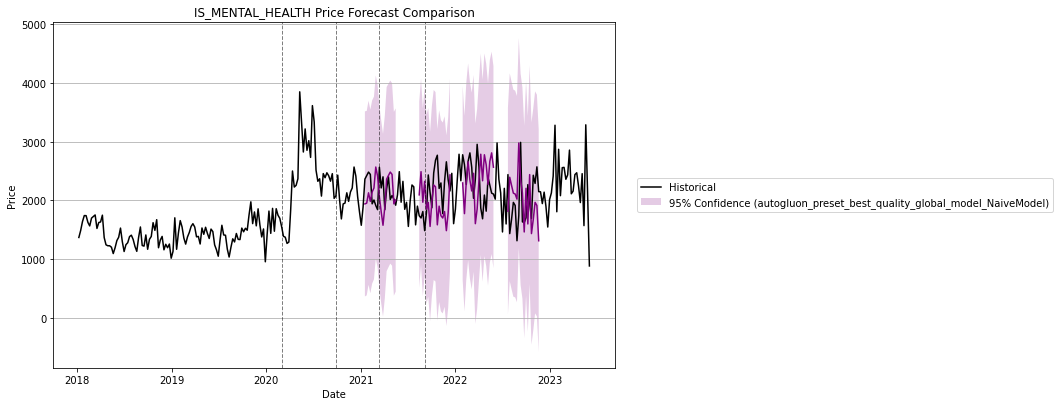

FileNotFoundError: [Errno 2] No such file or directory: './output/experiment_analysis/plots/IS_MENTAL_HEALTH_top3_models.png'

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_forecasts(category, context_df, forecast_dfs_by_method, actual_df, cutoff_dates, save_path=None, show_plots=True):

    # Create a figure with specified size
    fig = plt.figure(figsize=(12,6))

    # Define the positions of the axes and create them
    plot_ax = fig.add_axes([0.1, 0.1, 0.65, 0.8])  # left, bottom, width, height (range 0 to 1)
    legend_ax = fig.add_axes([0.77, 0.1, 0.2, 0.8])
    legend_ax.axis('off')  # Turn off the axes for the legend, so it's not visible


    # Combine context and actual data
    combined_df = pd.concat((context_df, actual_df))
    plot_ax.plot(combined_df.index, combined_df.values, color='black', label='Historical')

    colors = ['purple', 'orange', 'red']  # specify more colors if you have more methods

    for method_index, (method, forecast_dfs) in enumerate(forecast_dfs_by_method.items()):
        color = colors[method_index % len(colors)]

        for index, forecast_df in enumerate(forecast_dfs):
            # Confidence range between 0.05 and 0.95 quantiles (assuming these columns exist)
            plot_ax.fill_between(
                forecast_df.index,
                forecast_df["q_0.05"],
                forecast_df["q_0.95"],
                facecolor=color,
                alpha=0.2,
                label=f'95% Confidence ({method})' if index == 0 else None  # label only the first instance
            )

            # Add a line trace for the median
            plot_ax.plot(
                forecast_df.index,
                forecast_df["q_0.5"],
                color=color,
                # label=f'Median Forecast ({method})' if index == 0 else None  # label only the first instance
            )

    # Update the layout as needed
    plot_ax.set_title(f'{category} Price Forecast Comparison')
    plot_ax.set_xlabel('Date')
    plot_ax.set_ylabel('Price')
    for cutoff_date in cutoff_dates:
        plot_ax.axvline(pd.to_datetime(cutoff_date), color='black', ls='--', lw=1, alpha=0.5)

    # Generate legend from the plot_ax and apply it onto legend_ax
    handles, labels = plot_ax.get_legend_handles_labels()
    legend_ax.legend(handles, labels, loc='center left')

    plot_ax.xaxis.set_major_locator(mdates.YearLocator())
    plot_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plot_ax.grid(axis='y')

    # Show or save the figure based on input flags
    if show_plots:
        plt.show()

    if save_path:
        fig.savefig(save_path, dpi=300 if save_path.endswith("png") else None)  # High res for png



# Assuming df and mape_df are predefined
cutoff_dates = report_sim_dates

for category in df.columns:
    
    best_scores = mape_df.loc[mape_df.category == category].sort_values('mean_score').iloc[:3]
    context_df = df.loc[(df.index > "2018-01-01") & (df.index <= cutoff_dates[0])][category]
    actual_df = df.loc[df.index >= cutoff_dates[0]][category]

    forecast_dfs_by_method = {}  # a dictionary {method_name: forecast_dfs}

    # iterate over the most accurate experiments (i.e. model configurations)
    for index, (exp, cat, mean_score, std_score) in best_scores.iterrows():
        forecast_dfs = []

        # for each annual date in the list of cutoff dates, get this experiment's forecasts
        for date in cutoff_dates:
            forecast_csv_path = f"./output/experiments/{exp}/{date}/forecasts/{category}.csv"
            forecast_df = pd.read_csv(forecast_csv_path, index_col=0).iloc[-18:]
            forecast_df.index = pd.to_datetime(forecast_df.index)
            forecast_dfs.append(forecast_df)

        forecast_dfs_by_method[exp] = forecast_dfs

    # plot this experiment's forecasts along with the data in context_df and actual_df, which are the historical data
    plot_forecasts(
        category=category, 
        context_df=context_df, 
        forecast_dfs_by_method=forecast_dfs_by_method, 
        actual_df=actual_df, 
        cutoff_dates=cutoff_dates, 
        save_path=f"./output/experiment_analysis/plots/{category}_top3_models.png",  # change as needed
        show_plots=True
    )


In [17]:
best_results_6_year = []

for category in target_categories:

    # Identify the best-scoring experiment
    min_idx = mape_df.loc[mape_df.category == category]["mean_score"].idxmin()
    min_row = mape_df.loc[mape_df.category == category].loc[min_idx]
    best_results_6_year.append({"category": category, "top_experiment": min_row['experiment'], "mean_score": min_row['mean_score']})

best_results_6_year_df = pd.DataFrame(best_results_6_year)
best_results_6_year_df.to_csv("./output/experiment_analysis/best_results_6_year_single_models.csv")
best_results_6_year_df

,category,top_experiment,mean_score
0,Bakery and cereal products (excluding baby food),autogluon_ETSModel,0.023074
1,Dairy products and eggs,autogluon_AutoETSModel,0.020592
2,"Fish, seafood and other marine products",autogluon_global_with_covariates_experiment_Te...,0.016274
3,Food purchased from restaurants,autogluon_ETSModel,0.010429
4,Food,autogluon_RecursiveTabularModel,0.019692
5,"Fruit, fruit preparations and nuts",autoarima,0.036117
6,Meat,autogluon_ETSModel,0.024303
7,Other food products and non-alcoholic beverages,autogluon_RecursiveTabularModel,0.026523
8,Vegetables and vegetable preparations,autogluon_DeepARModel,0.038039


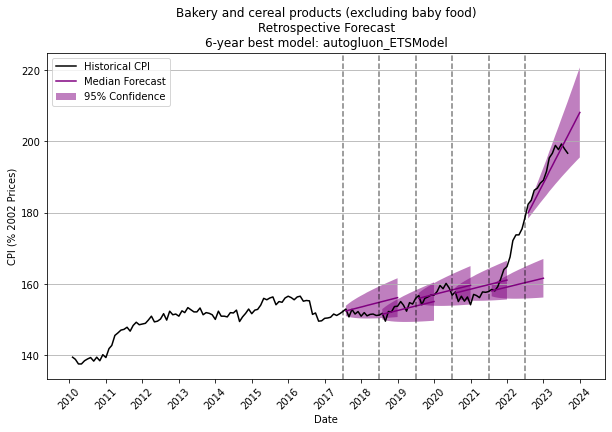

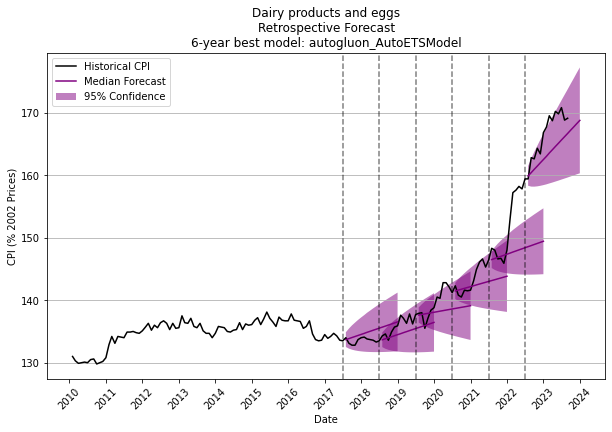

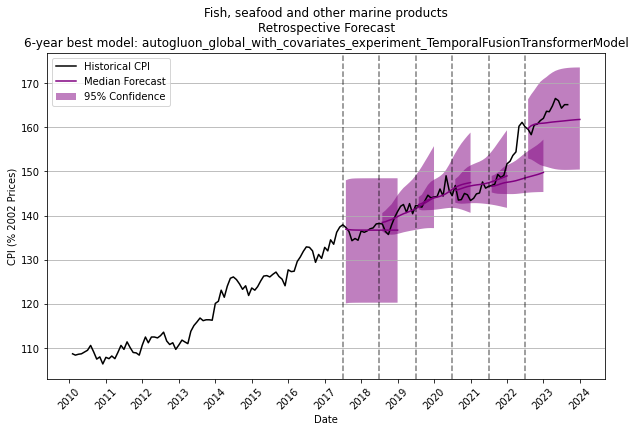

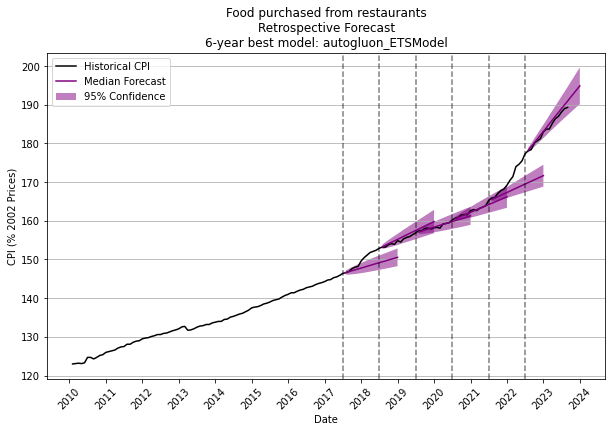

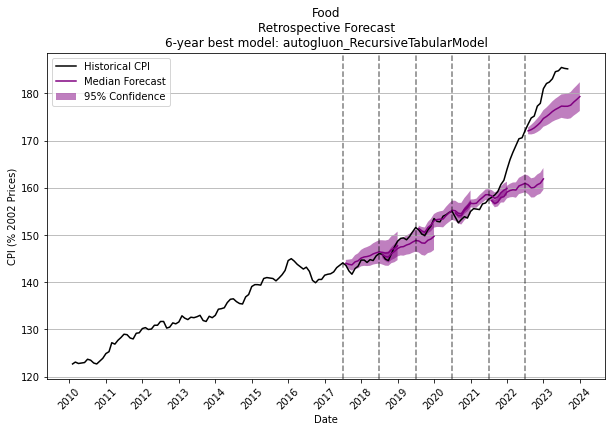

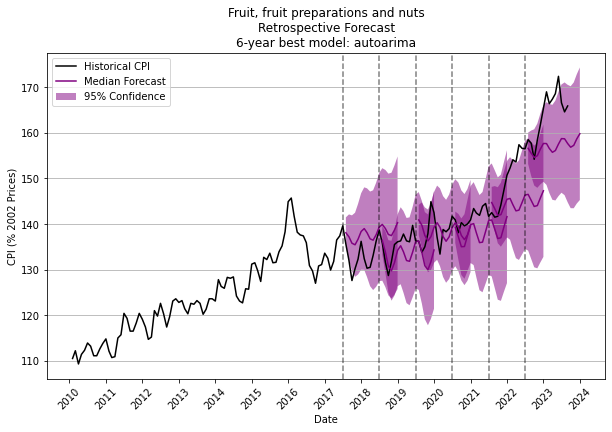

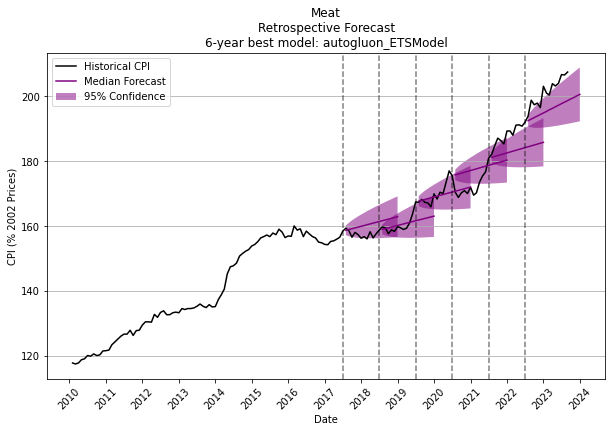

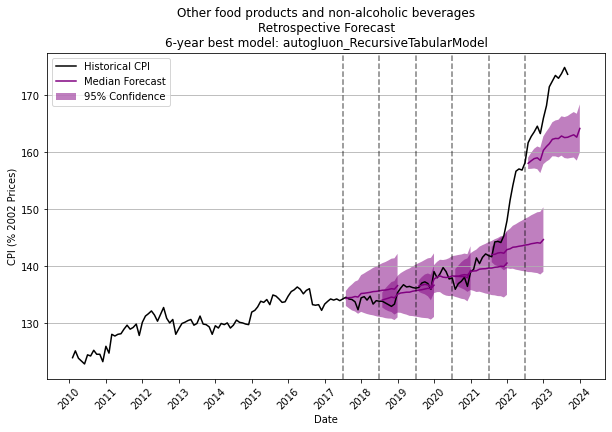

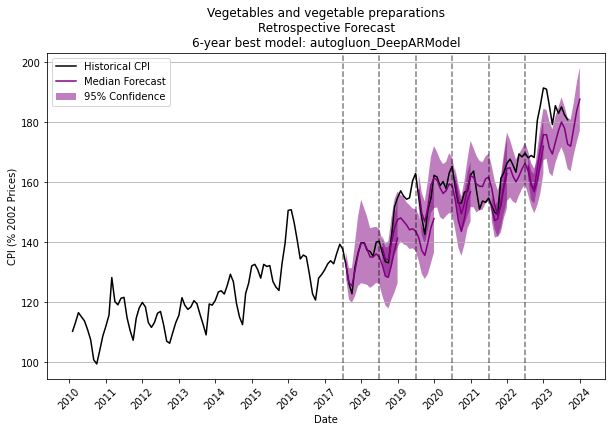

In [18]:
cutoff_dates = report_sim_dates

for index, (category, top_experiment, mean_score) in best_results_6_year_df.iterrows():
    forecast_dfs = []
    for date in cutoff_dates:
        forecast_csv_path = f"./output/experiments/{top_experiment}/{date}/forecasts/{category}.csv"
        forecast_df = pd.read_csv(forecast_csv_path, index_col=0).iloc[-18:]
        forecast_df.index = pd.to_datetime(forecast_df.index)
        forecast_dfs.append(forecast_df)
    combined_forecast_df = pd.concat(forecast_dfs, axis=0)
    context_df = foodprice_df.loc[(foodprice_df.index > "2010-01-01") & (foodprice_df.index <= cutoff_dates[0])][category]
    actual_df = foodprice_df.loc[foodprice_df.index >= cutoff_dates[0]][category]
    plot_quantile_forecasts(category, context_df, forecast_dfs, actual_df, cutoff_dates, model_name=f"6-year best model: {top_experiment}")


# 2-year analysis

In [19]:
mape_df = compute_all_scores(report_sim_dates[-2:], 'mape')
mape_df

,experiment,category,mean_score,std_score
0,autoarima,Bakery and cereal products (excluding baby food),0.078149,0.000364
1,autoarima,Dairy products and eggs,0.049542,0.005377
2,autoarima,"Fish, seafood and other marine products",0.027561,0.019110
3,autoarima,Food purchased from restaurants,0.025209,0.013053
4,autoarima,Food,0.050105,0.009264
...,...,...,...,...
229,autogluon_with_scaled_covariates_TemporalFusio...,Food,0.055649,0.004678
230,autogluon_with_scaled_covariates_TemporalFusio...,"Fruit, fruit preparations and nuts",0.082665,0.003146
231,autogluon_with_scaled_covariates_TemporalFusio...,Meat,0.061904,0.014248
232,autogluon_with_scaled_covariates_TemporalFusio...,Other food products and non-alcoholic beverages,0.053931,0.016071


In [20]:
mape_df.loc[mape_df.category == "Vegetables and vegetable preparations"].sort_values('mean_score')

,experiment,category,mean_score,std_score
98,autogluon_TemporalFusionTransformerModel,Vegetables and vegetable preparations,0.030572,0.006902
143,autogluon_with_covariates_TemporalFusionTransf...,Vegetables and vegetable preparations,0.032742,0.005378
233,autogluon_with_scaled_covariates_TemporalFusio...,Vegetables and vegetable preparations,0.038912,0.002843
215,autogluon_with_scaled_covariates_mean_SWE_Temp...,Vegetables and vegetable preparations,0.041597,0.002803
71,autogluon_DeepARModel,Vegetables and vegetable preparations,0.048508,0.007842
206,autogluon_global_with_scaled_covariates_experi...,Vegetables and vegetable preparations,0.051300,0.020251
179,autogluon_global_with_covariates_experiment_Te...,Vegetables and vegetable preparations,0.056569,0.010107
107,neuralprophet_uni,Vegetables and vegetable preparations,0.056925,0.001109
62,autogluon_DLinearModel,Vegetables and vegetable preparations,0.060728,0.000767
197,autogluon_global_with_scaled_covariates_experi...,Vegetables and vegetable preparations,0.060741,0.002330


In [21]:
best_results_2_year = []

for category in target_categories:

    # Identify the best-scoring experiment
    min_idx = mape_df.loc[mape_df.category == category]["mean_score"].idxmin()
    min_row = mape_df.loc[mape_df.category == category].loc[min_idx]
    best_results_2_year.append({"category": category, "top_experiment": min_row['experiment'], "mean_score": min_row['mean_score']})

best_results_2_year_df = pd.DataFrame(best_results_2_year)
best_results_2_year_df.to_csv("./output/experiment_analysis/best_results_2_year_single_models.csv")
best_results_2_year_df

,category,top_experiment,mean_score
0,Bakery and cereal products (excluding baby food),autogluon_ETSModel,0.044298
1,Dairy products and eggs,autogluon_TemporalFusionTransformerModel,0.030315
2,"Fish, seafood and other marine products",autogluon_ETSModel,0.024752
3,Food purchased from restaurants,autogluon_ETSModel,0.016717
4,Food,autogluon_TemporalFusionTransformerModel,0.035676
5,"Fruit, fruit preparations and nuts",autogluon_TemporalFusionTransformerModel,0.050232
6,Meat,autogluon_with_covariates_TemporalFusionTransf...,0.031795
7,Other food products and non-alcoholic beverages,autogluon_with_scaled_covariates_TemporalFusio...,0.053931
8,Vegetables and vegetable preparations,autogluon_TemporalFusionTransformerModel,0.030572


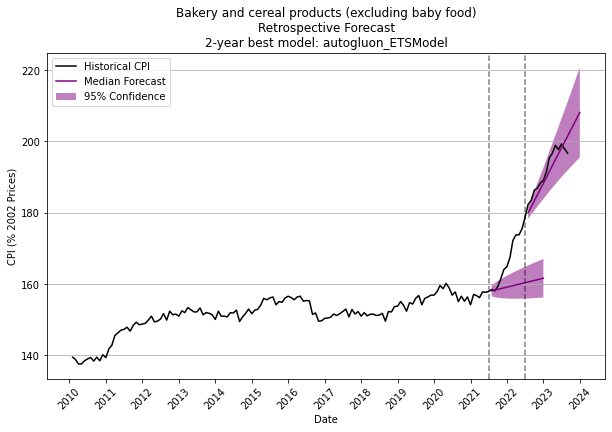

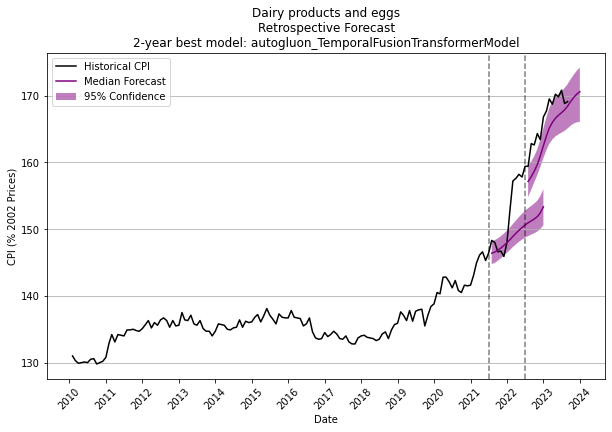

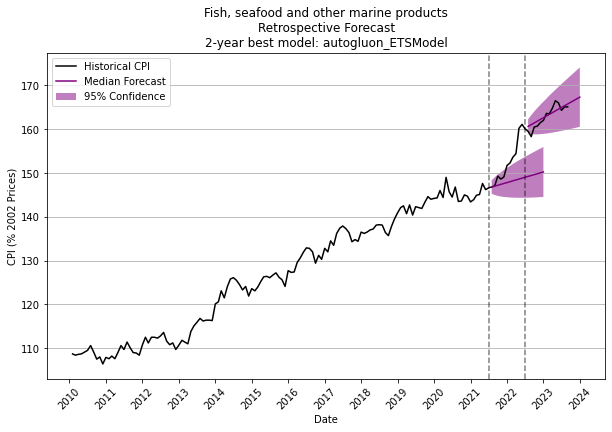

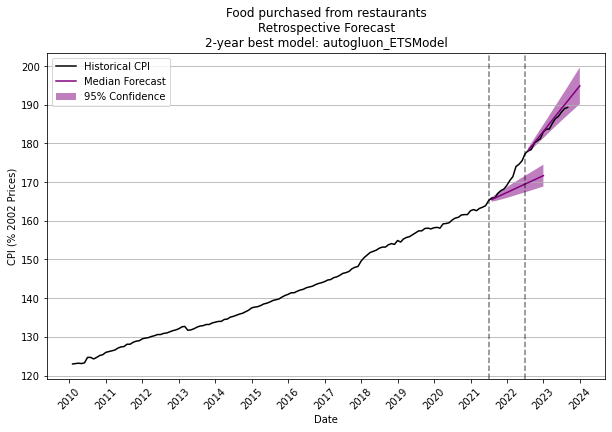

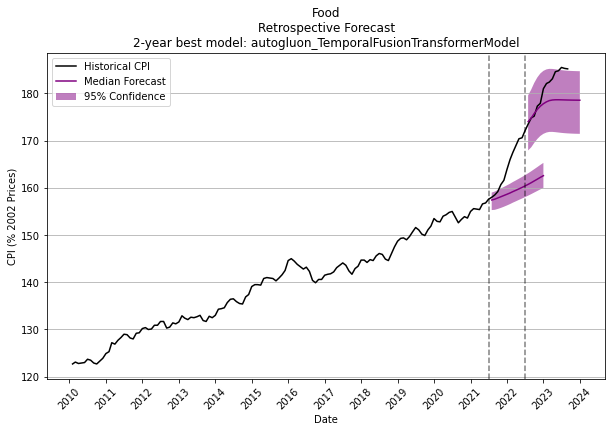

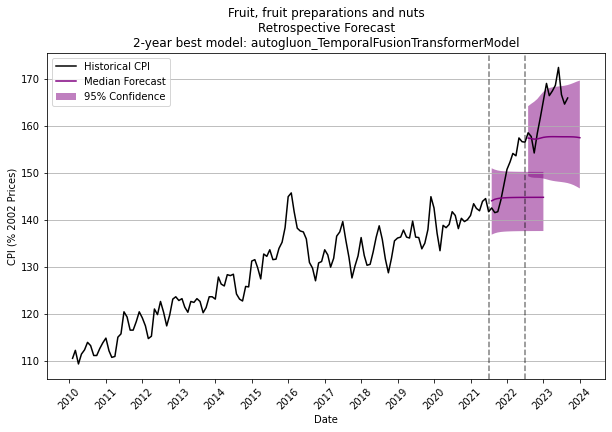

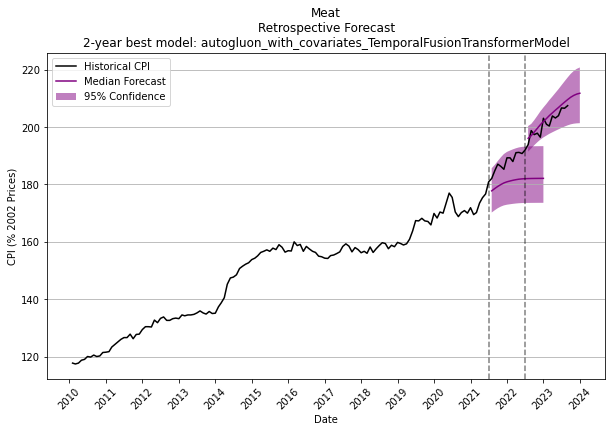

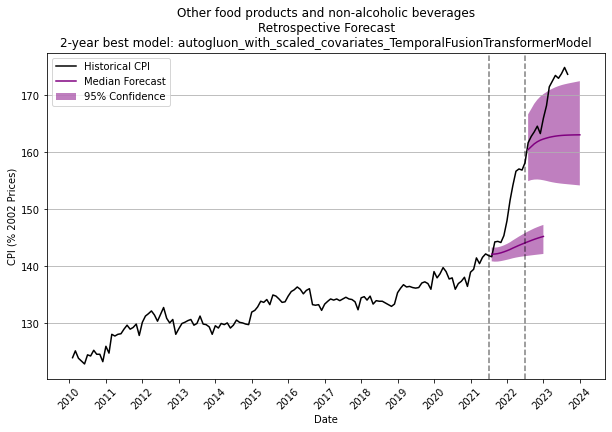

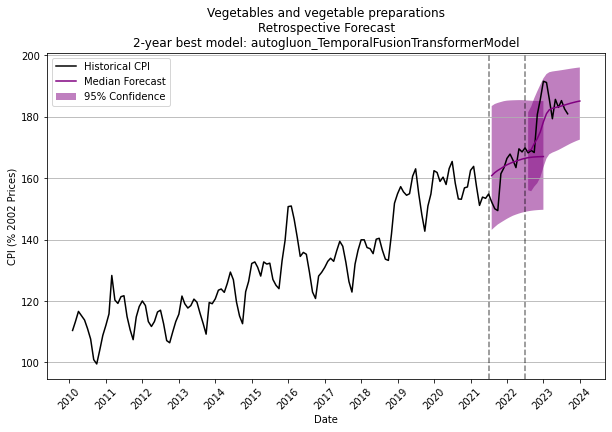

In [22]:
cutoff_dates = report_sim_dates[-2:]

for index, (category, top_experiment, mean_score) in best_results_2_year_df.iterrows():
    forecast_dfs = []
    for date in cutoff_dates:
        forecast_csv_path = f"./output/experiments/{top_experiment}/{date}/forecasts/{category}.csv"
        forecast_df = pd.read_csv(forecast_csv_path, index_col=0).iloc[-18:]
        forecast_df.index = pd.to_datetime(forecast_df.index)
        forecast_dfs.append(forecast_df)
    combined_forecast_df = pd.concat(forecast_dfs, axis=0)
    context_df = foodprice_df.loc[(foodprice_df.index > "2010-01-01") & (foodprice_df.index <= cutoff_dates[0])][category]
    actual_df = foodprice_df.loc[foodprice_df.index >= cutoff_dates[0]][category]
    plot_quantile_forecasts(category, context_df, forecast_dfs, actual_df, cutoff_dates, model_name=f"2-year best model: {top_experiment}")


todo
- add retrospective analysis for last year
- want to visualize error over time and compare error across years. We expect that some models were way off last year. Ideally we'd find some models that have good accurracy historically and were able to predict some of the spikes of the last two years. I mean otherwise really what is the point, unless it is to characterize "normal" or expected changes in prices

So, one quick thing to do would be to just check the MAPE over the last two years in the study and compare those to the prior 4 (or however many) years. I bet we'll see completely different models, which begs the question "how should we REALLY be doing model selection?" 